In [12]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [45]:
import pickle
from pathlib import Path
from typing import Union, Dict, Optional, List
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm

from camelsml.metrics import calc_nse

In [14]:
plt.style.use("../figstyle.mplstyle")

In [15]:
def load_results(folder: Union[Path, str], model_type: str, seed: int) -> Dict:
    if isinstance(folder, str):
        folder = Path(folder)
    if not folder.exists():
        raise FileNotFoundError(f"No directory found at {folder}")
    nse_values = defaultdict(dict)
    epochs = len(list(folder.rglob(f"{model_type}_seed{seed}_epoch_*.p")))
    if epochs == 0:
        raise FileNotFoundError(f"No validation runs found")
    for epoch in range(1, epochs + 1):
        file = folder / f"{model_type}_seed{seed}_epoch_{epoch}.p"
        with open(file, "rb") as results_file:
            results = pickle.load(results_file)
        for basin in results.keys():
            nse_values[f"epoch_{epoch}"][basin] = calc_nse(
                obs=results[basin]["qobs"].to_numpy(),
                sim=results[basin]["qsim"].to_numpy(),
            )
    return nse_values


def load_cv_results(
    main_folder: Union[Path, str], k, model_type: str, seed: int, epoch: int = 30
) -> Dict:
    if isinstance(main_folder, str):
        main_folder = Path(main_folder)
    if not main_folder.exists():
        raise FileNotFoundError(f"No directory found at {main_folder}")
    results = {}
    full_results = defaultdict(dict)
    for i in tqdm(range(k)):
        folder = main_folder / str(i)
        folder = list(folder.glob("*"))
        if len(folder) != 1:
            warnings.warn(f"Check your file structure in {i}")
        folder = folder[0]
        results[i] = load_results(folder, model_type, seed)
        for key in list(results[i].keys())[:epoch]:
            for basin in results[i][key].keys():
                full_results[key][basin] = results[i][key][basin]
    return full_results

In [57]:
def parse_results(
    folder: Union[str, Path], k: int = 5, skip: Optional[Union[int, List[int]]] = None
) -> Dict:
    if isinstance(skip, int):
        skip = [skip]
    folder = Path(folder)
    results = []
    for i in range(k):
        if i in skip:
            continue
        file = folder / f"{i}" / "i_list.pickle"
        with open(file, "rb") as infile:
            results.append(pickle.load(infile))
    return results


def calc_i(
    permutations: Dict,
    nse_values: Dict,
    epoch: int = 30,
    k: int = 5,
    min_nse=0,
    skip: Optional[Union[int, List[int]]] = None,
) -> pd.DataFrame:
    if isinstance(skip, int):
        skip = [skip]
    nse_values = nse_values[f"epoch_{epoch}"]
    means = defaultdict(lambda: defaultdict(lambda: 0))
    index = -1
    for i in range(k):
        if i in skip:
            print(f"skipped {i}!")
            continue
        else:
            index += 1
        print(f"Trying index {index} with len(permutations)={len(permutations)}")
        fold = permutations[index]
        features = list(fold.keys())
        for feature in features:
            feature_results = fold[feature]
            for k_ in list(feature_results.keys()):
                for basin in feature_results[k_].keys():
                    feature_results[k_][basin]
                    means[feature][basin] += feature_results[k_][basin] / len(
                        list(feature_results.keys())
                    )
    for feature in features:
        for basin in means[feature].keys():
            if nse_values[basin] >= min_nse:
                means[feature][basin] = nse_values[basin] - means[feature][basin]
            else:
                means[feature][basin] = np.nan

    return pd.DataFrame.from_dict(means).dropna()

In [17]:
k = 5
permutations = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_cv/permutation/",
    k=k,
)
nse_values = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_cv/",
    model_type="ealstm",
    seed="19970204",
    k=k,
)
importance_all_features = calc_i(permutations, nse_values, k=k, min_nse=0.7)

100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


In [18]:
print(importance_all_features.idxmin())
nse_values["epoch_30"]["39036"]

gauge_easting     54024
gauge_northing    54024
gauge_elev        54024
area              54024
elev_min          54024
                  ...  
frac_mod_perc     54024
frac_low_perc     54024
no_gw_perc        54024
low_nsig_perc     54024
nsig_low_perc     54024
Length: 76, dtype: object


-20.826532323937354

In [19]:
def importance_metrics(importances: pd.DataFrame, limit: float = 0.1) -> pd.DataFrame:
    fracs = defaultdict(dict)
    for feature in importances.columns:
        fracs[feature][f"Amount i > {limit}"] = (importances[feature] > limit).sum()
        fracs[feature][f"Fraction i > {limit}"] = fracs[feature][
            f"Amount i > {limit}"
        ] / len(importances[feature])
        fracs[feature][f"Max"] = importances[feature].max()
        fracs[feature][
            "|i|"
        ] = f"{importances[feature].mean():.4f}+-{importances[feature].std():.2f}"
        fracs[feature][f"median(i)"] = np.median(importances[feature])
    df = pd.DataFrame.from_dict(fracs).T.sort_values(
        f"Fraction i > {limit}", ascending=False
    )
    return df


fracs_all_features = importance_metrics(importance_all_features, limit=0.1)
# fracs_all_features.loc["dpsbar"]

Q95 b'Q95'
baseflow\_index\_ceh b'baseflow\\_index\\_ceh'
porosity\_hypres\_5 b'porosity\\_hypres\\_5'
num\_reservoir b'num\\_reservoir'


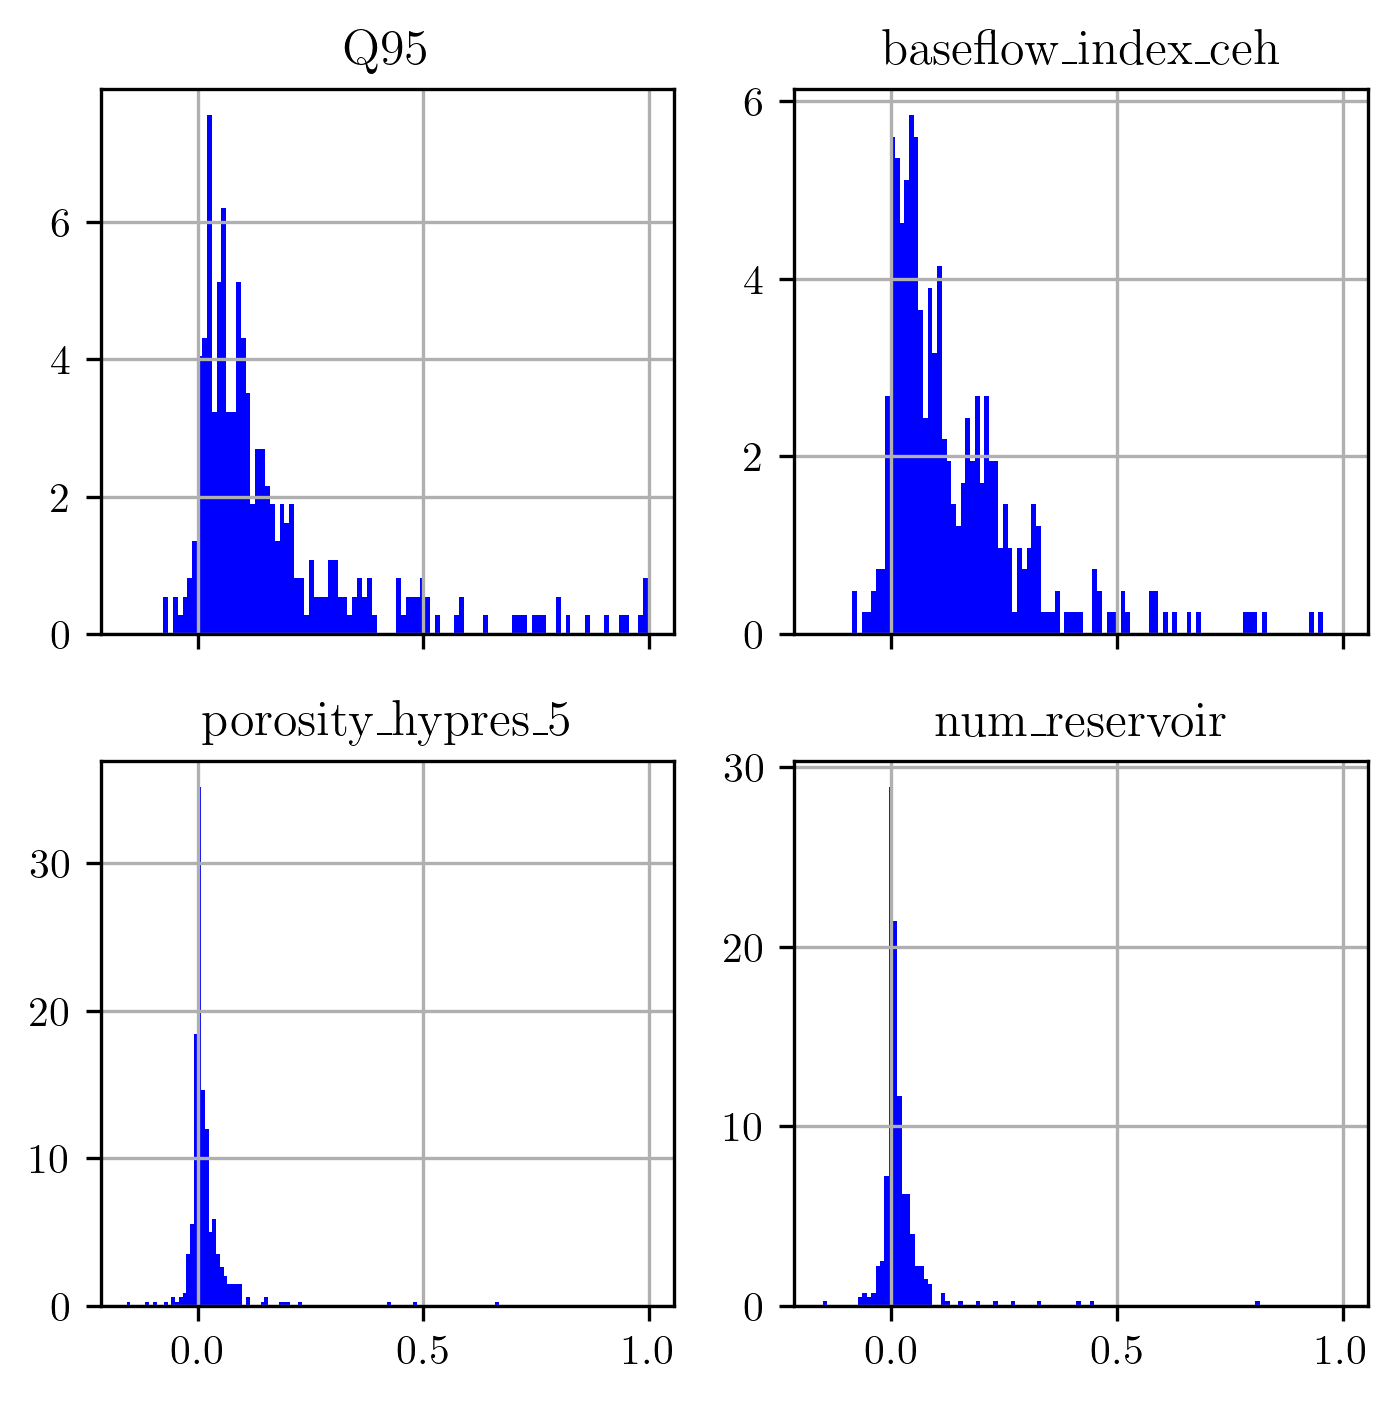

In [41]:
def plot_importances(
    importances: pd.DataFrame,
    feature: str,
    ax: Optional[plt.Axes] = None,
    color: str = "blue",
    label: Optional[str] = None,
):
    x = importances[feature][importances[feature] <= 1]
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.hist(x, facecolor=color, bins=100, density=True, label=label)


fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = ["Q95", "baseflow_index_ceh", "porosity_hypres_5", "num_reservoir"]

save_path = Path("../doc/thesis/figures/permutation/all_features_cv")
save_path.mkdir(exist_ok=True, parents=True)

for i, feature in enumerate(features):
    plot_importances(importance_all_features, feature, ax=axes[i])
    print(
        feature.replace("_", "\\_"),
        feature.replace("_", "\\_").encode(encoding="UTF-8"),
    )
    axes[i].set_title(feature.replace("_", "\_"))
    axes[i].grid()
fig.tight_layout()
"""matplotlib.use("pgf")
matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)
fig.savefig(save_path / "histogram_all.pgf")"""
fig.savefig(save_path / "histogram_all.pdf")
# plt.show()

## The above results seem to imply that the EA-LSTM model likes extra precipitation info.
Possibly because the timeseries do not contain enough information? Or maybe sequence_length should be increased?

## The results below indicate that not many basins care about the "physical" features
This is model dependent, will do the same analysis of the reduced model to see if this is still the case

In [9]:
chosen_features = np.genfromtxt(
    "../runs/correlation_reduction/chosen_features/use_features.txt", dtype="str"
)
# BUG!!
chosen_features = chosen_features[
    np.logical_and(chosen_features != "dpsbar", chosen_features != "dom_land_cover")
]
fracs_all_features.loc[chosen_features, :].sort_values(
    "Amount i > 0.1", ascending=False
)

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
area,50,0.120482,0.833907,0.0367+-0.08,0.0148686
elev_50,44,0.106024,0.73686,0.0353+-0.09,0.00945725
elev_10,39,0.0939759,1.17161,0.0371+-0.11,0.00992119
inwater_perc,34,0.0819277,0.439951,0.0301+-0.06,0.0130615
urban_perc,33,0.0795181,1.63305,0.0360+-0.12,0.00950176
conductivity_hypres,33,0.0795181,0.655942,0.0252+-0.07,0.00767327
dwood_perc,27,0.0650602,1.20341,0.0314+-0.10,0.00949244
elev_90,26,0.0626506,0.71461,0.0295+-0.08,0.0106345
ewood_perc,26,0.0626506,0.697971,0.0238+-0.07,0.00661051
root_depth,26,0.0626506,0.959221,0.0255+-0.08,0.00730795


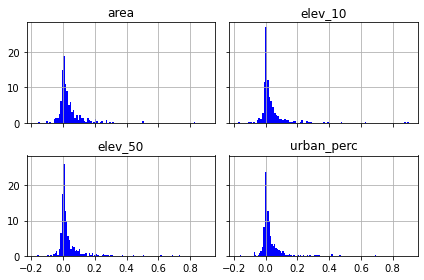

In [10]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.flatten()

features = ["area", "elev_10", "elev_50", "urban_perc"]

for i, feature in enumerate(features):
    plot_importances(importance_all_features, feature, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].grid()
fig.tight_layout()
plt.show()

## Importance of reduced, physically based system.

In [11]:
k = 5
permutations_chosen_features = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_cv/permutation/",
    k=k,
)
nse_values_chosen_features = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_cv/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=14,
)
importance_chosen_features = calc_i(
    permutations_chosen_features, nse_values_chosen_features, k=k, min_nse=0.7, epoch=14
)

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


In [12]:
fracs_chosen_features = importance_metrics(importance_chosen_features, limit=0.1)
fracs_chosen_features

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
inwater_perc,45,0.130435,1.43286,0.0534+-0.17,0.00407905
no_gw_perc,45,0.130435,19.3281,0.0899+-1.04,0.00944002
area,41,0.118841,0.932298,0.0347+-0.08,0.00513449
crop_perc,40,0.115942,31.629,0.1256+-1.71,0.00640409
frac_high_perc,37,0.107246,19.8167,0.1152+-1.09,2.20189e-09
urban_perc,36,0.104348,1.03296,0.0315+-0.10,0.00256599
conductivity_hypres,35,0.101449,5.82341,0.0444+-0.32,0.00356607
frac_low_perc,34,0.0985507,4.56128,0.0513+-0.29,0.00392283
tawc,29,0.084058,0.675057,0.0233+-0.07,0.00464144
dwood_perc,27,0.0782609,2.93985,0.0337+-0.19,0.00361339


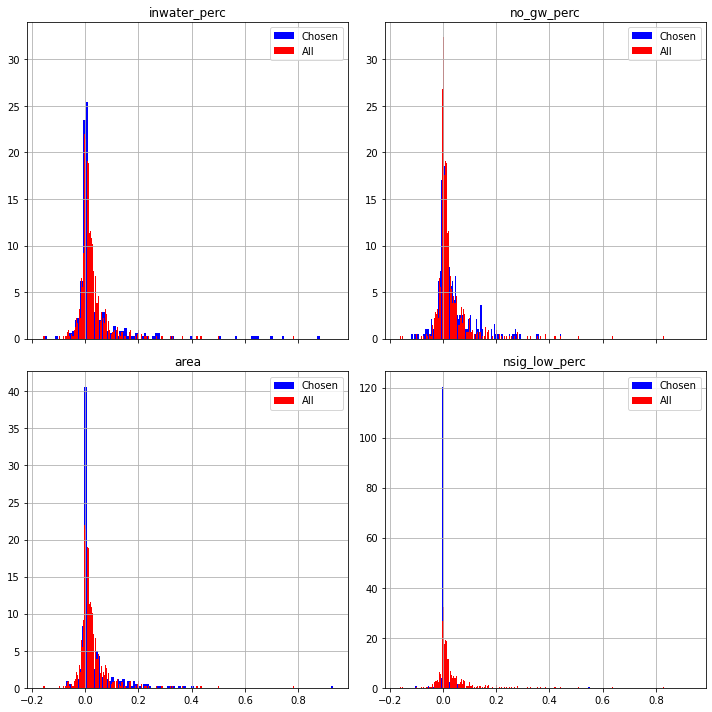

In [13]:
fig, axes = plt.subplots(
    2, 2, sharex=True, sharey=False, figsize=[10, 10]
)  # , figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = ["inwater_perc", "no_gw_perc", "area", "nsig_low_perc"]

for i, feature in enumerate(features):
    plot_importances(
        importance_chosen_features, feature, ax=axes[i], color="blue", label="Chosen"
    )
    plot_importances(
        importance_all_features, features, ax=axes[i], color="red", label="All"
    )
    axes[i].legend()
    axes[i].set_title(feature)
    axes[i].grid()
fig.tight_layout()
plt.show()

## Importance of fixed all feature run

In [14]:
k = 5
permutations_all_features_fixed = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_fixed_cv/permutation/",
    k=k,
)
nse_values_all_features_fixed = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_fixed_cv/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=20,
)
importance_all_features_fixed = calc_i(
    permutations_all_features_fixed,
    nse_values_all_features_fixed,
    k=k,
    min_nse=0.7,
    epoch=20,
)

100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


In [15]:
fracs_all_features_fixed = importance_metrics(importance_all_features_fixed, limit=0.1)
fracs_all_features_fixed

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
inwater_perc,45,0.12894,1.31303,0.0426+-0.14,0.00311364
frac_high_perc,35,0.100287,2.36039,0.0433+-0.17,8.88597e-11
area,30,0.0859599,0.804576,0.0264+-0.07,0.00502305
root_depth,25,0.0716332,1.09983,0.0259+-0.09,0.00319256
conductivity_hypres,25,0.0716332,2.7376,0.0271+-0.16,0.00171413
tawc,22,0.0630372,1.04598,0.0239+-0.09,0.0036163
urban_perc,22,0.0630372,0.619906,0.0243+-0.09,0.00161141
grass_perc,20,0.0573066,0.434,0.0178+-0.05,0.00359146
dwood_perc,19,0.0544413,0.529958,0.0173+-0.06,0.00197587
gauge_northing,18,0.0515759,2.07553,0.0248+-0.15,0.00101215


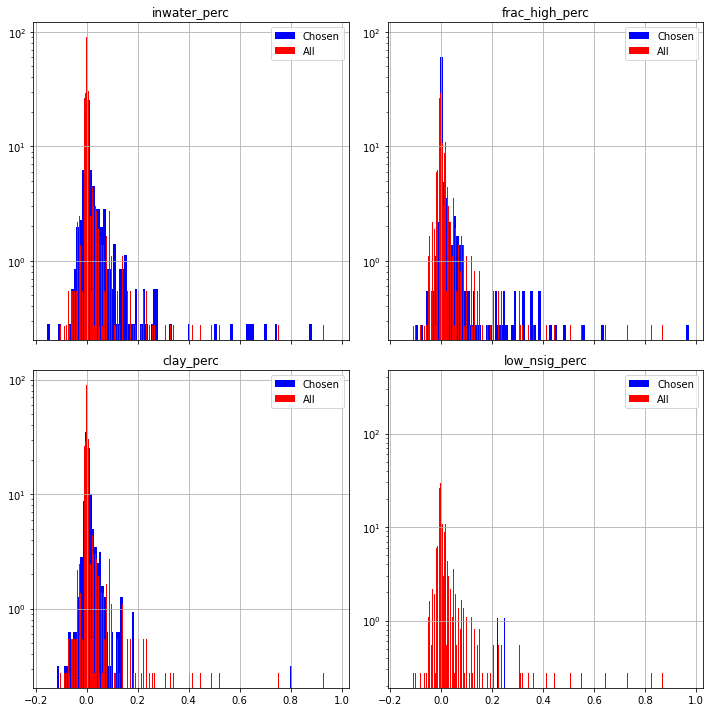

In [16]:
fig, axes = plt.subplots(
    2, 2, sharex=True, sharey=False, figsize=[10, 10]
)  # , figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = ["inwater_perc", "frac_high_perc", "clay_perc", "low_nsig_perc"]

for i, feature in enumerate(features):
    plot_importances(
        importance_chosen_features, feature, ax=axes[i], color="blue", label="Chosen"
    )
    plot_importances(
        importance_all_features_fixed, features, ax=axes[i], color="red", label="All"
    )
    axes[i].legend()
    axes[i].set_title(feature)
    axes[i].grid()
    axes[i].set_yscale("log")
fig.tight_layout()
plt.show()

## Importance CAMELS-US vs CAMELS-GB
### CAMELS-US:

There is a bug in the permutation test code that caused the test to skip root_depth in camels-us...

In [20]:
k = 5
permutations_common_features_us = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_us/permutation/",
    k=k,
)
nse_values_common_features_us = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_us/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=20,
)
importance_common_features_us = calc_i(
    permutations_common_features_us,
    nse_values_common_features_us,
    k=k,
    min_nse=0.7,
    epoch=20,
)

100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


In [21]:
fracs_common_features_us = importance_metrics(importance_common_features_us, limit=0.1)
fracs_common_features_us

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
elev_mean,46,0.351145,7.15657,0.2159+-0.71,0.0319029
clay_frac,36,0.274809,1.67622,0.0796+-0.17,0.035069
area_gages2,25,0.19084,0.691085,0.0583+-0.10,0.016815
sand_frac,23,0.175573,1.02403,0.0593+-0.12,0.023619
soil_conductivity,22,0.167939,2.30253,0.0631+-0.22,0.00985595
silt_frac,19,0.145038,2.03345,0.0599+-0.20,0.0168996
soil_depth_pelletier,18,0.137405,4.92582,0.0887+-0.45,0.00462735
organic_frac,8,0.0610687,3.0998,0.0366+-0.27,0
water_frac,2,0.0152672,0.204145,0.0040+-0.02,0


### CAMELS-GB:

In [22]:
k = 5
permutations_common_features_gb = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_gb/permutation/",
    k=k,
)
nse_values_common_features_gb = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_gb/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=20,
)
importance_common_features_gb = calc_i(
    permutations_common_features_gb,
    nse_values_common_features_gb,
    k=k,
    min_nse=0.7,
    epoch=20,
)

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


In [23]:
fracs_common_features_gb = importance_metrics(importance_common_features_gb, limit=0.1)
fracs_common_features_gb

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
root_depth,97,0.284457,28.8013,0.2052+-1.59,0.0413055
clay_perc,72,0.211144,75.572,0.3075+-4.11,0.00860962
conductivity_cosby,68,0.199413,2.23905,0.1002+-0.25,0.00773143
elev_50,49,0.143695,1.0119,0.0552+-0.13,0.0105209
organic_perc,47,0.13783,1.58214,0.0636+-0.18,0.0109007
inwater_perc,39,0.11437,1.46228,0.0430+-0.14,0.00174713
area,37,0.108504,0.659095,0.0376+-0.08,0.00811301
silt_perc,29,0.085044,1.48982,0.0323+-0.12,0.00430266
sand_perc,19,0.0557185,0.587203,0.0169+-0.06,0.00201834
soil_depth_pelletier,19,0.0557185,0.551797,0.0148+-0.05,0.000554654


Skipped root_depth in CAMELS-US


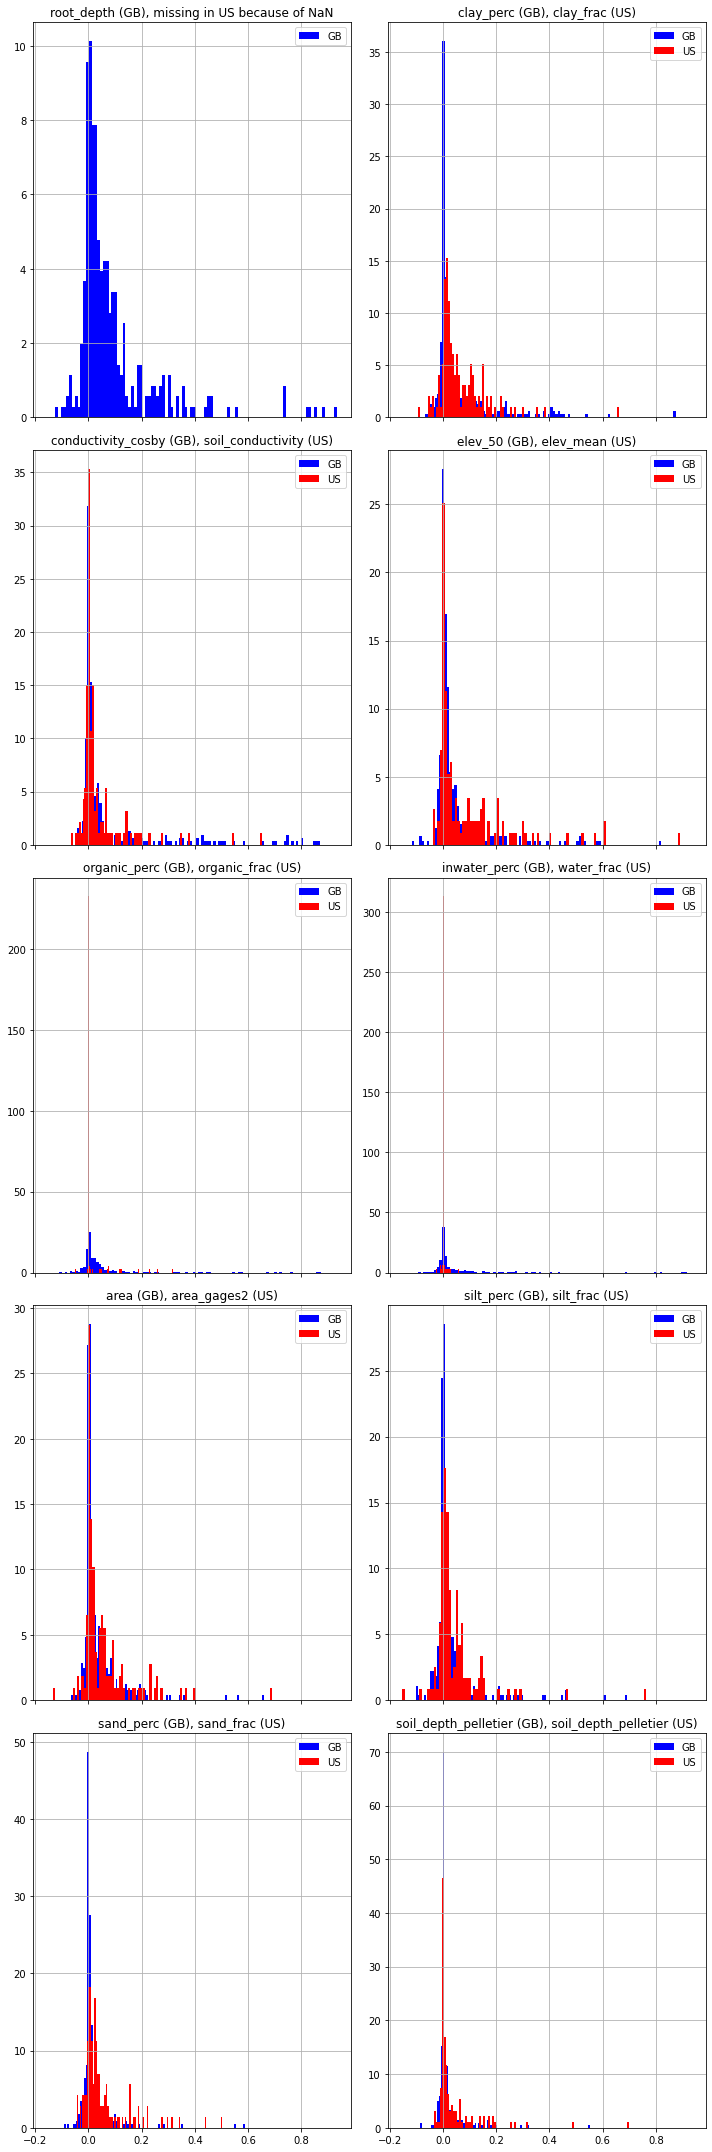

In [32]:
fig, axes = plt.subplots(
    5, 2, sharex=True, sharey=False, figsize=[10, 30]
)  # , figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = {
    "root_depth": "missing",
    "clay_perc": "clay_frac",
    "conductivity_cosby": "soil_conductivity",
    "elev_50": "elev_mean",
    "organic_perc": "organic_frac",
    "inwater_perc": "water_frac",
    "area": "area_gages2",
    "silt_perc": "silt_frac",
    "sand_perc": "sand_frac",
    "soil_depth_pelletier": "soil_depth_pelletier",
}

for i, feature in enumerate(features.keys()):
    plot_importances(
        importance_common_features_gb, feature, ax=axes[i], color="blue", label="GB"
    )
    axes[i].set_title(f"{feature} (GB), missing in US because of NaN")
    try:
        plot_importances(
            importance_common_features_us,
            features[feature],
            ax=axes[i],
            color="red",
            label="US",
        )
        axes[i].set_title(f"{feature} (GB), {features[feature]} (US)")
    except KeyError:
        print(f"Skipped {feature} in CAMELS-US")
    axes[i].legend()

    axes[i].grid()
    # axes[i].set_yscale("log")
fig.tight_layout()
plt.show()

### Kratzert third paper features

In [58]:
k = 3
permutations_kratzert_features_us = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/kratzert_features_cv_us/permutation/",
    k=k,
    skip=0,
)
nse_values_kratzert_features_us = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/camels_us/kratzert_features_cv_us/",
    model_type="lstm",
    seed="19970204",
    k=k,
    epoch=30,
)
importance_kratzert_features_us = calc_i(
    permutations_kratzert_features_us,
    nse_values_kratzert_features_us,
    k=k,
    min_nse=0.7,
    epoch=30,
    skip=0,
)

100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

skipped 0!
Trying index 0 with len(permutations)=2
Trying index 1 with len(permutations)=2


In [60]:
fracs_kratzert_features_us = importance_metrics(
    importance_kratzert_features_us, limit=0.1
)
fracs_kratzert_features_us

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
frac_snow,17,0.257576,0.433773,0.0683+-0.11,0.00974538
area_gages2,15,0.227273,5.99589,0.2061+-0.77,0.0201732
slope_mean,15,0.227273,0.797477,0.0692+-0.14,0.0164049
high_prec_freq,15,0.227273,0.318584,0.0584+-0.08,0.0346241
elev_mean,14,0.212121,0.416472,0.0591+-0.09,0.0231223
low_prec_freq,13,0.19697,1.18497,0.0628+-0.16,0.0153343
gvf_max,13,0.19697,0.319739,0.0476+-0.08,0.0127747
p_mean,12,0.181818,2.41276,0.1093+-0.34,0.0163776
aridity,12,0.181818,0.549519,0.0539+-0.09,0.0197197
gvf_diff,12,0.181818,0.237353,0.0440+-0.06,0.0304448


## Notes on feature importances
Kratzert et al did not run a static feature importance analysis on the third paper (the one with testing on ungauged basins). On the second paper when he ran a feature importance analysis he observed that mean precipitation was the most important feature. To me this could in theory imply that the gauged basin model uses the mean precipitation as a simple way to "recognize" each basin (this possibility Felix mentioned earlier too). My results here indicate that the snow fraction is more important than in Kratzert's analysis. What these results do agree with however is that hydrological information is more important than land coverage and soil attributes. A bit dissapointing for physical understanding, perhaps? Could always train a new model without these hydrological features to see how that performs, though!

Also, the fact that static information about precipitation like high_prec_frec is still deemed important to me implies that there is potential for improving our LSTM model in the future. All that information should be able to be taken from the time series, implying to me that the LSTM has potential to learn more time dependencies than it does now. 

## Combined dataset. Some notes.

* Times series are differnent. Only 3 in common. (I use 6 right now for CAMELS-GB, Kratzert uses 5 for CAMELS-US)
    - This I already knew though, and it would be interesting to look at a reduced set of itme series anyway.
* Land coverage information is structured differently. 
    - CAMELS-US only has fractions for the dominant land cover for each basin. CAMELS-GB has much more information here as it contains fractions from several land covers.
* There are some attributes I think could be comparable to each other. 
    - |CAMELS-US | CAMELS-GB |
      |-------------------|-----------------|
      |sand_frac|sand_perc|
      |silt_frac|silt_perc|
      |clay_frac|clay_perc|
      |organic_frac|organic_perc|
      |max_water_content|tawc (unsure)|
      |root_depth_XX|root_depth (Both are available as percentiles)|
      |soil_depth_pelletier|soil_depth_pelletier|
      |soil_conductivity|conductivity_(hypres or cosby?)|
      |soil_porosity|soil_porosity_(hypres or cosby?)|
      |||



Camels US: Dominating land cover [string],   CAMELS GB: all land covers
           coverage fraction of dominating,  coverage fraction of several types
           
This leads to:

1: The model gets the fraction of dominating, but no context for it.

2: Same as above, but also include land cover type as input (this input is non-numerical)